# Views and describes the data, before much processing.

In [1]:
#default_exp surveyors

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn
from mizani.formatters import date_format

#export
import restaurants_timeseries.core as core

In [4]:
def get_earliest_date(dat):
    return dat.query("visitors > 0")['visit_date'].min()


def get_latest_date(dat):
    return dat.query("visitors > 0")['visit_date'].max()


#export
class VisitsSurveyor:
    def __init__(self, visits: core.pd.DataFrame, make_report: bool):
        self.make_report = make_report
        self.visits = visits
        self.assign_never_visited()
        self.filter_zero_periods()
        self.count_visited_days()
        self.get_populated_spans()
        self.plot_spans()
        self.visits = self.visits.sort_values(['air_store_id', 'visit_date'], ascending=True)
    
    def report(self, s: str) -> None:
        if self.make_report:
            if issubclass(type(s), core.pd.DataFrame):
                display(s)
            else:
                print(s)
        
    def assign_never_visited(self) -> None:        
        self.store_counts = self.visits.groupby('air_store_id').visitors.sum()
        self.never_visited = self.store_counts[self.store_counts == 0]
        self.report("The visits data looks like this:")
        self.report(self.visits.head())
        self.report(" ")        
        self.report(f"There are {len(self.store_counts)} stores.")
        self.report(f"{len(self.never_visited)} stores had no visits ever.")

    def filter_zero_periods(self) -> None:
        self.daily_total_visits = (
            self.visits
            [['visit_date', 'visitors']]
            .groupby('visit_date')
            .sum()
            .reset_index())
        earliest_day = get_earliest_date(self.daily_total_visits)
        latest_day = get_latest_date(self.daily_total_visits)
        self.visits = self.visits[
            (self.visits.visit_date >= earliest_day) &
            (self.visits.visit_date <= latest_day)]
        self.report(f"Populated data is from {earliest_day} to {latest_day}.")
        
    def count_visited_days(self) -> None:
        self.visited_days_counts = (
            self.visits[self.visits.visitors > 0].
            groupby('air_store_id')['visitors'].
            count().
            reset_index(name='days_visited'))
        hist = (
            pn.ggplot(self.visited_days_counts, pn.aes(x='days_visited')) +
            pn.geom_histogram(bins=60) +
            pn.theme_bw() +
            pn.labs(x = "days visited", y = "count restaurants") +
            pn.theme(figure_size=(13, 3)))
        if self.make_report:
            self.report("")
            self.report("Visited days per restaurant:")
            display(hist)
            
    def get_populated_spans(self) -> core.pd.DataFrame:
        rows = []
        for store_id, df in self.visits.groupby('air_store_id'):
            earliest_day = get_earliest_date(df)
            latest_day = get_latest_date(df)
            row = (store_id, earliest_day, latest_day)
            rows.append(row)
        spans = core.pd.DataFrame(
            rows, columns=['air_store_id', 'earliest_visit_date', 'latest_visit_date'])
        spans['length'] = spans['latest_visit_date'] - spans['earliest_visit_date']
        spans.sort_values('length', inplace=True)
        spans['air_store_id'] = core.pd.Categorical(spans.air_store_id, 
                                                    categories=core.pd.unique(spans.air_store_id))
        self.spans = spans
        
    def plot_spans(self):
        x = 'air_store_id'
        spans_plot = (
            pn.ggplot(self.spans, pn.aes(x=x, xend=x, 
                                         y='earliest_visit_date', yend='latest_visit_date')) +
            pn.geom_segment(color='gray') +
            pn.theme_bw() +
            pn.scale_y_date(breaks="1 month", labels=date_format("%b %Y")) +
            pn.theme(figure_size=(30, 4), axis_text_x=pn.element_blank(), 
                     axis_ticks_minor_x=pn.element_blank(), axis_ticks_major_x=pn.element_blank(),
                     axis_text_y=pn.element_text(size=10),
                     panel_grid=pn.element_blank()))
        if self.make_report:
            # takes long, so comment out during development
            display(spans_plot)
            #pass 
        

The visits data looks like this:


,air_store_id,air_genre_name,air_area_name,latitude,longitude,visit_date,day_of_week,holiday_flg,visitors
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-01,Friday,1,0
1,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-02,Saturday,1,0
2,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-03,Sunday,1,0
3,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-04,Monday,0,0
4,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,2016-01-05,Tuesday,0,0


 
There are 829 stores.
0 stores had no visits ever.
Populated data is from 2016-01-01 00:00:00 to 2017-04-22 00:00:00.

Visited days per restaurant:


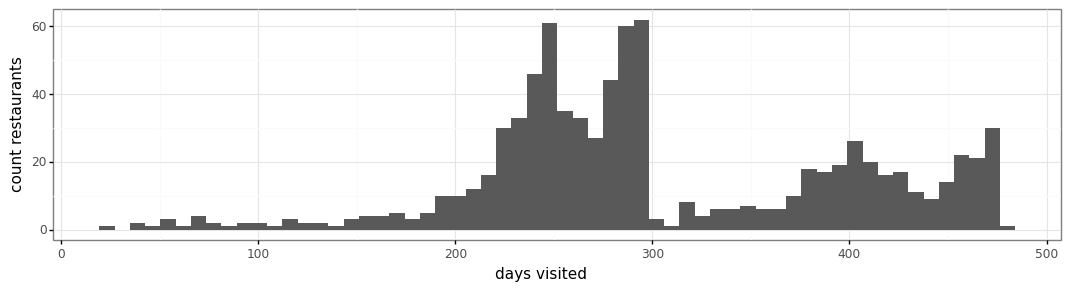

<ggplot: (8629763147954)>

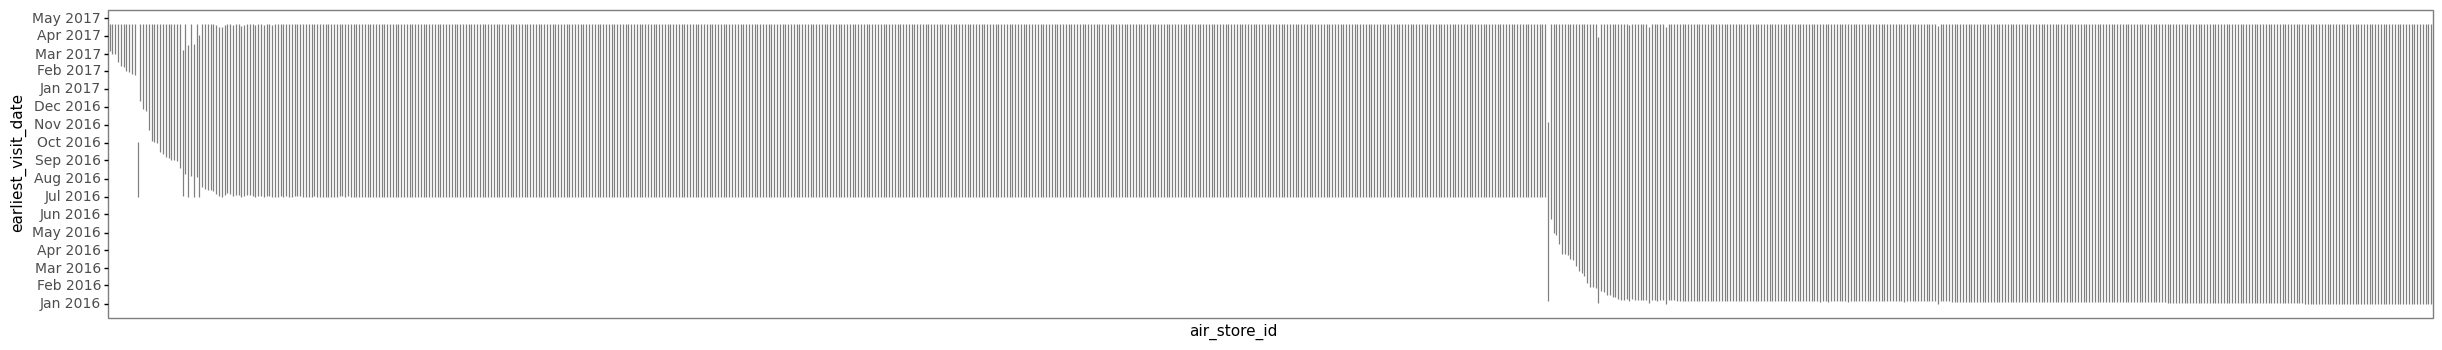

<ggplot: (8629763028191)>

In [5]:
vs = VisitsSurveyor(core.data['visits'], True)

In [6]:
#export
vs = VisitsSurveyor(core.data['visits'], False)
populated_store_id = (
    vs.visited_days_counts
    .sort_values(by='days_visited', ascending=False)
    .air_store_id[0])

In [7]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_view_data.ipynb.
Converted 02_model_one.ipynb.
Converted index.ipynb.
